In [ ]:
%load_ext nb_black

In [115]:
import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split

# Modelling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Binning
import woeBinningPandas

Data: https://www.kaggle.com/wordsforthewise/lending-club

In [10]:
# Read data
accepted = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
rejected = pd.read_csv("rejected_2007_to_2018Q4.csv", low_memory=False)

## KGB Model

In [499]:
# Sample 100k obs. for easy processing
accepted_small = accepted.sample(n=25000, random_state=7)
accepted_small.reset_index(drop=True, inplace=True)

In [500]:
# Create Default Flag
accepted_small["target"] = accepted_small["loan_status"].apply(
    lambda x: 1 if x == "Charged Off" else (0 if x == "Fully Paid" else 2)
)

In [501]:
# Remove Current and Missings
accepted_small = accepted_small.loc[accepted_small["target"] != 2]
accepted_small.shape

(14838, 152)

In [502]:
pd.crosstab(accepted_small["target"], accepted_small["loan_status"])

loan_status,Charged Off,Fully Paid
target,,
0,0,11809
1,3029,0


The dataset is imbalanced

In [503]:
# Keep only 2 explanatory variables for quick an dirty PD model
df = accepted_small[["id", "target", "loan_amnt", "addr_state"]]

In [504]:
# Q&D Bucketing

#Loan Amount
df["loan_amnt2"] = df["loan_amnt"].apply(
    lambda x: "<=1k"
    if (x <= 1000)
    else ("1-10k" if (x > 1000 and x <= 10000) else ">10k")
)

In [505]:
#State
binning = woeBinningPandas.woe_binning (df, "target", "addr_state", 0.1, 0.1, 50, 100, "bad")

In [506]:
badstates = binning["Group_1"][:25].tolist()
california = ['CA']
goodstates = binning["Group_1"][27:].tolist()

In [507]:
df["addr_state2"] = df["addr_state"].apply(
    lambda x: "California"
    if (x == "CA")
    else ("Bad state" if (x in badstates) else "Good state")
)

In [508]:
df2 = df[["id", "target", "loan_amnt2", "addr_state2"]]

Text(0, 0.5, 'Proportion of Accepts')

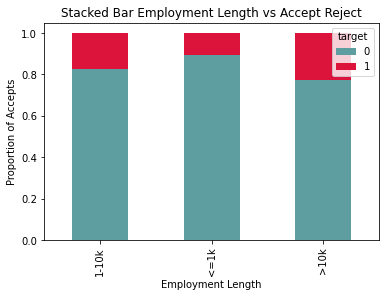

In [509]:
# Explore differentiation 
%matplotlib inline
table = pd.crosstab(df2["loan_amnt2"], df2["target"])
table.div(table.sum(1).astype(float), axis=0).plot(
    kind="bar", color=["cadetblue", "crimson"], stacked=True
)
plt.title("Stacked Bar Employment Length vs Accept Reject")
plt.xlabel("Employment Length")
plt.ylabel("Proportion of Accepts")

In [510]:
pd.crosstab(df2["loan_amnt2"], df2["target"]).apply(lambda r: r / r.sum(), axis=1)

target,0,1
loan_amnt2,,
1-10k,0.823922,0.176078
<=1k,0.892308,0.107692
>10k,0.775151,0.224849


Text(0, 0.5, 'Proportion of Accepts')

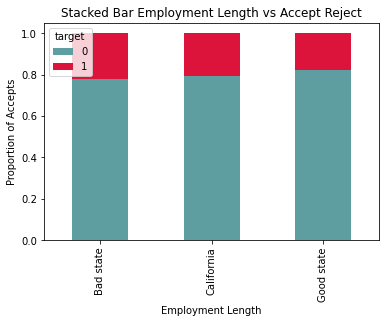

In [511]:
# Explore differentiation
%matplotlib inline
table = pd.crosstab(df2["addr_state2"], df2["target"])
table.div(table.sum(1).astype(float), axis=0).plot(
    kind="bar", color=["cadetblue", "crimson"], stacked=True
)
plt.title("Stacked Bar Employment Length vs Accept Reject")
plt.xlabel("Employment Length")
plt.ylabel("Proportion of Accepts")

In [512]:
pd.crosstab(df2["addr_state2"], df2["target"]).apply(lambda r: r / r.sum(), axis=1)

target,0,1
addr_state2,,
Bad state,0.779883,0.220117
California,0.793533,0.206467
Good state,0.823040,0.176960


In [513]:
df2

,id,target,loan_amnt2,addr_state2
0,139076511,0,>10k,Good state
2,1469880,0,1-10k,Good state
3,76014793,1,>10k,Bad state
4,71775585,1,>10k,Bad state
5,61394422,0,>10k,Bad state
...,...,...,...,...
24993,77088654,0,1-10k,Good state
24994,7079415,0,>10k,Bad state
24995,136379900,0,>10k,Bad state
24997,114082267,0,1-10k,Bad state


In [514]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2"]

for i in modelling_variables:
    if i != "target":
        df2 = df2.join(pd.get_dummies(df2[i]))
        df2 = df2.drop([i], axis=1)

In [515]:
# Drop Null Band
df3 = df2.drop(
    columns=[
        "1-10k",
        "California"
    ]
)

In [516]:
X = df3.loc[:, df3.columns != "target"]
y = df3.loc[:, df3.columns == "target"]

In [517]:
# Balance the data
os = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
columns = X_train.columns

In [518]:
# Train
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=["target"])

# we can check the numbers of our data
print(
    "The number of observations in Development data before undersampling is ",
    len(X_train),
)
print(
    "The number of observations in Development data after undersampling is ",
    len(os_data_X),
)

The number of observations in Development data before undersampling is  10386
The number of observations in Development data after undersampling is  6357


In [519]:
# Keep only columns for modelling
os_data_X_2 = os_data_X[["<=1k", ">10k", "Good state", "Bad state"]]
X_test_2 = X_test[["<=1k", ">10k", "Good state", "Bad state"]]

In [520]:
# Build Logistic regression
# Statmodels
logit_model = sm.Logit(os_data_y, os_data_X_2.astype(float))
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.642610
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.010   
Dependent Variable: target           AIC:              8178.1454
Date:               2020-10-30 12:15 BIC:              8205.1747
No. Observations:   6357             Log-Likelihood:   -4085.1  
Df Model:           3                LL-Null:          -4046.3  
Df Residuals:       6353             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
<=1k        -1.0993    0.6306   -1.7432  0.0813  -2.3353   0.1367
>10k        -0.0021    0.0480   -0.0444  0.9646  -0.0962   0.0920
Good sta

Accuracy score Logistic Regression: 0.7955974842767296


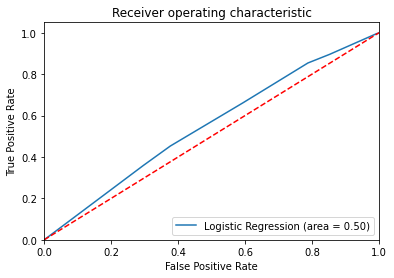

In [521]:
# Sklearn
logreg = LogisticRegression()
logreg.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = logreg.predict(X_test_2)
print("Accuracy score Logistic Regression:", logreg.score(X_test_2, y_test))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_2)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [522]:
# Merge actual and predicted

y_hats = logreg.predict(X_test_2)
y_hats = pd.DataFrame(y_hats)

df_out = X_test_2.reset_index()
df_out["Actual"] = y_test.reset_index()["target"]
df_out["Prediction"] = y_hats.reset_index()[0]
y_test["prediction"] = y_hats

df_out = pd.merge(
    df, y_test[["prediction"]], how="left", left_index=True, right_index=True
)

df_out

,id,target,loan_amnt,addr_state,loan_amnt2,addr_state2,prediction
0,139076511,0,20000.0,SC,>10k,Good state,NaN
2,1469880,0,1600.0,CT,1-10k,Good state,NaN
3,76014793,1,32000.0,MO,>10k,Bad state,0.0
4,71775585,1,28425.0,PA,>10k,Bad state,NaN
5,61394422,0,26000.0,PA,>10k,Bad state,NaN
...,...,...,...,...,...,...,...
24993,77088654,0,8000.0,CT,1-10k,Good state,NaN
24994,7079415,0,21000.0,FL,>10k,Bad state,NaN
24995,136379900,0,15000.0,IL,>10k,Bad state,NaN
24997,114082267,0,5500.0,KY,1-10k,Bad state,NaN


In [527]:
# Remove NaNs (Null Band + non-test set)
df_out.dropna(subset=["prediction"], inplace=True)

In [528]:
# Preprocessing for creating DF
df_out["count"] = df_out.groupby(["target", "prediction"])["target"].transform("count")
df_out2 = df_out[["prediction", "target", "count"]]
df_out3 = df_out2.drop_duplicates()
df_out3.reset_index(drop=True, inplace=True)

In [529]:
# Create "book example" dataframe
df_out3["target_0"] = df_out3.apply(
    lambda row: row["count"] if row["target"] == 0 else np.nan, axis=1
)
df_out3["target_1"] = df_out3.apply(
    lambda row: row["count"] if row["target"] == 1 else np.nan, axis=1
)
df_target_0 = df_out3[["prediction", "target_0"]]
df_target_1 = df_out3[["prediction", "target_1"]]
df_target_0.dropna(inplace=True)
df_target_1.dropna(inplace=True)
df_out4 = pd.merge(df_target_0, df_target_1, on="prediction")

In [530]:
# Rename columns
df_out4.rename(columns={"target_0": "Good", "target_1": "Bad"}, inplace=True)
# Create percentages
df_out4["Perc_Good"] = df_out4["Good"] / (df_out4["Good"] + df_out4["Bad"])
df_out4["Perc_Bad"] = df_out4["Bad"] / (df_out4["Good"] + df_out4["Bad"])

In [531]:
df_out4

,prediction,Good,Bad,Perc_Good,Perc_Bad
0,0.0,609.0,156.0,0.796078,0.203922


## Apply the KGB Model (Logistic Regression) to the Rejects

In [532]:
# Sampling
rejected_small = rejected.sample(n=25000, random_state=7)
rejected_small.reset_index(drop=True, inplace=True)
rejected_small.rename(columns={"Amount Requested": "loan_amnt"}, inplace=True)
rejected_small.rename(columns={"State": "addr_state"}, inplace=True)
dfr = rejected_small[["loan_amnt", "addr_state"]]

In [533]:
# Q&D Bucketing
dfr["loan_amnt2"] = dfr["loan_amnt"].apply(
    lambda x: "<=1k"
    if (x <= 1000)
    else ("1-10k" if (x > 1000 and x <= 10000) else ">10k")
)

dfr["addr_state2"] = dfr["addr_state"].apply(
    lambda x: "California"
    if (x == "CA")
    else ("Bad state" if (x in badstates) else "Good state")
)

In [534]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2"]

for i in modelling_variables:
    if i != "target":
        dfr = dfr.join(pd.get_dummies(dfr[i]))
        dfr = dfr.drop([i], axis=1)

In [535]:
# Drop Null Band
dfr2 = dfr.drop(columns=["loan_amnt", "addr_state", "1-10k", "California"])

In [536]:
# Predictions
rej_test_predictions = logreg.predict_proba(dfr2)[:,1]
df_pred_rej = pd.DataFrame(data=rej_test_predictions, columns=["prediction"])
df_pred_rej["Rejects"] = df_pred_rej.groupby("prediction")["prediction"].transform(
    "count"
)
df_pred_rej.groupby(["prediction"]).count()

,Rejects
prediction,
0.158055,970
0.186416,167
0.202216,541
0.257858,7749
0.297793,1535
0.315883,5682
0.319329,4064
0.360440,1174
0.384028,3118


### Reject Inference: Simple Augmentation

In [537]:
#Reject Inference with cutoff 0.2
df_pred_rej["prediction2"] = df_pred_rej["prediction"].apply(
    lambda x: 0
    if (x < 0.2) else 1)
df_pred_rej2 = df_pred_rej["prediction2"]
ri1 = pd.DataFrame(data=df_pred_rej2, columns=["prediction2"])
ri1.rename(columns={"prediction2": "prediction"}, inplace=True)

In [538]:
ri1

,prediction
0,1
1,1
2,1
3,1
4,1
...,...
24995,1
24996,1
24997,0
24998,1


### K-Means

to-do:
- grid search/hypterparameter optimization
- visualization

In [539]:
kmeans = KMeans(init="random", n_clusters=2, n_init=10, max_iter=300, random_state=7)

In [540]:
kmodel = kmeans.fit(dfr2)

In [541]:
kmeans.inertia_

9957.044743917244

In [542]:
kmeans.cluster_centers_

array([[6.58100365e-02, 3.96828153e-01, 8.33535915e-01, 1.27120536e-14],
       [7.00504985e-02, 4.03729121e-01, 5.44009282e-15, 1.00000000e+00]])

In [543]:
kmeans.n_iter_

2

In [544]:
kmeans.labels_

array([0, 0, 1, ..., 0, 0, 0])

In [545]:
# Predictions
rej_test_predictions_kmeans = kmeans.labels_
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()

,Rejects
prediction,
0,17277
1,7723


### Reject Inference K-means

In [441]:
ri2 = pd.DataFrame(data=df_pred_rej_kmeans, columns=["prediction"])
ri2

,prediction
0,0
1,0
2,1
3,0
4,0
...,...
24995,0
24996,1
24997,0
24998,0


### Hierarchical Clustering

In [443]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(dfr2)

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [446]:
# Predictions
rej_test_predictions_aggl = cluster.labels_
df_pred_rej_aggl = pd.DataFrame(
    data=rej_test_predictions_aggl, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_aggl.groupby("prediction")[
    "prediction"
].transform("count")

### Reject Inference Hierarchical Clustering

In [447]:
ri3 = pd.DataFrame(data=df_pred_rej_kmeans, columns=["prediction"])
ri3

,prediction
0,0
1,0
2,1
3,0
4,0
...,...
24995,0
24996,1
24997,0
24998,0


### Join all RI Predictions together

In [457]:
merged = ri1.join(ri2, on=None, lsuffix='_RI1_Augmen', rsuffix='_RI2_KMeans',)
merged2 = merged.join(ri3, on=None)
merged2.rename(columns={"prediction": "prediction_RI3_Agglom"}, inplace=True)

### OPTICS

In [88]:
from sklearn.cluster import OPTICS

In [89]:
clustering = OPTICS(min_samples=2).fit(dfr3)
clustering.labels_

array([0, 1, 0, ..., 1, 0, 1])

In [91]:
clustering_optics

,prediction,Rejects
0,0,53841
1,1,39529
2,0,53841
3,0,53841
4,1,39529
...,...,...
99995,2,6630
99996,0,53841
99997,1,39529
99998,0,53841


In [90]:
# Predictions
clustering_optics = clustering.labels_
clustering_optics = pd.DataFrame(
    data=clustering_optics, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_optics.groupby("prediction")[
    "prediction"
].transform("count")
clustering_optics.groupby(["prediction"]).count()

,Rejects
prediction,
0,53841
1,39529
2,6630


### MeanShift

In [92]:
from sklearn.cluster import MeanShift

In [93]:
clustering2 = MeanShift(bandwidth=2).fit(dfr3)
clustering2.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [94]:
# Predictions
clustering_meanshift = clustering2.labels_
clustering_meanshift = pd.DataFrame(
    data=clustering_meanshift, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_meanshift.groupby("prediction")[
    "prediction"
].transform("count")
clustering_meanshift.groupby(["prediction"]).count()

""
prediction
0


### SVM

In [61]:
# Accepts
clf = SVC(gamma="auto", kernel="linear")
clf.fit(os_data_X_2, os_data_y.values.ravel())
pred = clf.predict(X_test_2)

In [62]:
# Predictions
rej_test_predictions_kmeans = clf.predict(dfr3)
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()

,Rejects
prediction,
0,100000
